# Modeling scooter rides in Paris

Scooter ecosystem analysis

## Questions

- How large is the fleet of the different operating companies?
- How many rides are being made on scooters of different vendors?
- What % of the scooter fleet is active at any time?
- Which area in Paris is the most interesting to deploy scooters in?

# Table of contents

1. Main objectives <br>
2. Data exploration <br>
    2.1. Return and delete duplicate rows <br>
    2.2. Return rows with nulls <br>
    2.3. Vendor field <br>
    2.4. Battery level field <br>
    2.5. Time field <br>
    2.6. Longitude field <br>
    2.7. Latitude field <br>
3. Number of scooters per vendor <br>
4. Number of rides per vendor <br>
    4.1. Analyze data for one scooter to better understand the data <br>
    4.2. Apply the same approach for all the scooters in the dataset <br>
    4.3. Calculate the number of rides per vendor <br>
    4.4. Lime ride data imputation <br>
5. Scooter utilization <br>
    5.1 Daily active scooter fleet per vendor <br>
    5.2. Hourly fleet utilization ratio <br>
    5.3. Daily fleet utilization ratio <br>
6. Integrating geospatial data into the analysis <br>
    6.1. A point-in-polygon problem <br>
    6.2. The most interesting areas in Paris to deploy scooters in <br>

## 1. Main objectives

- Visualise the size of supply at any given time
- Quantify the number of trips within a certain time window
- Visualise the hotzones (zones with high user demand and low vehicle density) and coldzones (zones with low user demand and high density)

## 2. Data exploration

- Explore the data and dive into any irregularities
- What kind of data cleaning is required?
- Are we seeing duplicates?
- What data is missing?
- What geographical area are we covering?

In [1]:
# import Python libraries
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import geopandas as gpd
import descartes

from datetime import datetime, date, time

In [2]:
# load the flat file
df_filename = 'data-rides.csv'
df = pd.read_csv(df_filename,header=0, parse_dates=['time'])

In [3]:
# read the first 10 rows
df.head(10)

,time,scooter_id,vendor,lat,lng,battery_level
0,2019-04-09 19:03:07.809000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0
1,2019-04-09 18:03:04.599000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0
2,2019-04-09 19:03:01.263000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0
3,2019-04-09 18:03:13.194000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0
4,2019-04-09 18:03:09.912000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0
5,2019-04-09 18:02:59.014000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0
6,2019-04-09 19:03:27.907000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0
7,2019-04-09 19:03:02.566000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0
8,2019-04-09 18:02:59.014000+00:00,dGllcjpTQ09PVEVSOjE5NjM1,Tier,48.900578,2.229933,0
9,2019-04-09 18:03:13.194000+00:00,dGllcjpTQ09PVEVSOjE5NjM1,Tier,48.900578,2.229933,0


In [4]:
# read the last 10 rows
df.tail(10)

,time,scooter_id,vendor,lat,lng,battery_level
7572962,2019-03-14 00:01:31.076000+00:00,dm9pOlNDT09URVI6NTg2NTljOTQtY2VjNy00ZGIwLWIyNT...,Voi,48.832352,2.267198,100
7572963,2019-03-14 09:02:05.668000+00:00,ET-FNBJ2OEVQCJDSVLO4XZWM6RKDU3L2B7ZLMQQPEY,Lime,48.831776,2.270868,10
7572964,2019-03-15 17:02:28.364000+00:00,ET-K7N5X553AK7HVBWCPKLDNNK256EOVDC4HYHXVDQ,Lime,48.836634,2.271548,100
7572965,2019-03-15 17:02:28.364000+00:00,ET-QSQJYRXG7OCGIZR4SN44JI5SP6GGZM3WLYPK5JY,Lime,48.836726,2.271951,100
7572966,2019-03-15 17:02:28.364000+00:00,ET-ZM6LND5OV4MLO35OED35YX6HL3BOYJWIEN7DNEI,Lime,48.833066,2.276816,100
7572967,2019-03-15 20:02:22.771000+00:00,ET-USMYUBQR4W2HGHUZHERN4UT6PSXQZHKWHV3D2DY,Lime,48.831506,2.272113,100
7572968,2019-03-16 16:02:27.289000+00:00,ET-FDFS3NWF5XKUMGKVE3UINYP6AMM2JGJOD3PARFQ,Lime,48.831506,2.272113,100
7572969,2019-03-16 16:02:27.289000+00:00,ET-NVYEDQLEIVJJKHUOIJ4Z3YL6SHE6UIPPCL3TUXA,Lime,48.830393,2.272609,60
7572970,2019-03-16 16:02:27.289000+00:00,ET-Q3LSUDOPLNSA3LVGUPAHKECCHSRVZLZX2Z5K6LI,Lime,48.833896,2.271057,100
7572971,2019-03-17 00:02:30.720000+00:00,ET-VMWWADUFPFZOBWQV2ERFDEA3FEP4POD3ZP634CQ,Lime,48.830393,2.272609,60


In [5]:
# return the no. of rows in the table
df.count()

time             7572972
scooter_id       7572972
vendor           7572972
lat              7572972
lng              7572972
battery_level    7572972
dtype: int64

## Dataset Schema

- <b> time </b>: timestamp at which vehicle is observed 
- <b> scooter_id </b>: identifier from public API 
- <b> vendor </b>: scooter company
- <b> lat </b>: vehicle lat
- <b> lng </b>: vehicle longitude
- <b> battery_level </b>: vehicle battery level

The scooter data is a snapshot of the vehicle locations at different points in time. There are many rows for a single scooter allowing to track its location. There are 7,572,972 observations. 

The data covers Paris in March 2019 and beginning of April 2019 at hourly intervals, although it is uncertain whether every area is updated every hour.

There is no specific ride data about rides, including ride start time, ride end time and the distance covered during the trip. The rides need to be approximated using other variables. There is also no information about the users.

## 2.1. Return and delete duplicate rows

There are 565 duplicated rows.

In [6]:
# return duplicated rows of data
duplicateRows = df[df.duplicated()]
duplicateRows

,time,scooter_id,vendor,lat,lng,battery_level
12407,2019-04-09 23:01:20.787000+00:00,S0006685,Wind,48.848117,2.308476,53
14053,2019-04-09 21:02:24.356000+00:00,aGl2ZTpTQ09PVEVSOjExNjcx,Hive,48.885601,2.296396,55
48472,2019-04-09 23:01:20.787000+00:00,dm9pOlNDT09URVI6ZjExYWVmYjAtMGQ4NS00NmYxLTk0Zj...,Voi,48.848030,2.305511,85
65548,2019-04-09 23:01:20.787000+00:00,dm9pOlNDT09URVI6NDVkYTRhOWMtYTNlNi00ZmY4LWI4OD...,Voi,48.846836,2.307557,99
65591,2019-04-09 23:01:20.787000+00:00,dm9pOlNDT09URVI6NzMwNmUyMWEtMmM2YS00MTE3LWE1OT...,Voi,48.847124,2.307173,99
...,...,...,...,...,...,...
7523494,2019-03-14 21:03:24.375000+00:00,dm9pOlNDT09URVI6NDU5YzIzMDYtY2UzMi00MmY1LTlkZD...,Voi,48.865685,2.321032,92
7523515,2019-03-14 21:03:24.375000+00:00,dm9pOlNDT09URVI6NmUwMDRiY2UtNjI0My00M2NhLTgzND...,Voi,48.865742,2.321552,92
7523528,2019-03-14 21:03:24.375000+00:00,dm9pOlNDT09URVI6ODdiY2RmZjYtZTljMC00ZTllLTlmYW...,Voi,48.865665,2.321041,92
7523539,2019-03-14 21:03:24.375000+00:00,dm9pOlNDT09URVI6YjcwMmJhOWUtOTNhOS00ZWJhLTllOD...,Voi,48.865730,2.321096,93


In [7]:
# drop duplicated rows
df = df.drop_duplicates()

In [8]:
df.count()

time             7572407
scooter_id       7572407
vendor           7572407
lat              7572407
lng              7572407
battery_level    7572407
dtype: int64

## 2.2. Return rows with nulls

In [9]:
# Check the no. of unknown records in the columns
df.isnull().sum()

time             0
scooter_id       0
vendor           0
lat              0
lng              0
battery_level    0
dtype: int64

## 2.3. Vendor field

There are eight different scooter companies.

In [10]:
# no. of records grouped by vendor
df['vendor'].value_counts()

Bird     2087093
Voi      1857469
Flash     936531
Wind      835934
Tier      777922
Hive      744466
Lime      264939
Bolt       68053
Name: vendor, dtype: int64

## 2.4. Battery level field

The battery level is an integer between 0 and 101. It equals 101 for 12 rows.

The most common battery level is 100, followed by 99 and 98, indicating that scooters are very often fully charged and idle, waiting for a ride.

In [11]:
# battery level sorted
pd.set_option('display.max_rows', 102)
df['battery_level'].value_counts()

100    1498183
99      199384
98      182206
93      147572
96      145700
97      142789
94      139352
60      134779
92      133443
91      130613
95      124979
89      119054
90      117943
80      117868
76      111123
87      106671
85      106505
79      105969
59      105739
74      105630
72      104621
88      104021
70      103220
83      102992
78      102679
75      101682
71       99775
73       96782
84       94766
69       94429
81       93786
67       90589
82       89166
65       88200
66       85373
77       85262
63       82970
86       82124
62       80471
64       80041
68       74453
61       72857
57       66645
58       64510
55       63074
54       61443
56       61065
53       60236
51       58090
52       56653
40       55671
49       48148
37       47917
47       47839
39       47500
38       47335
50       47322
46       46926
36       46845
48       46507
44       44218
35       43680
45       42681
34       42666
43       42100
42       41925
33       4

In [12]:
# max battery level
max(df['battery_level'])

101

In [13]:
# min battery level
min(df['battery_level'])

0

## 2.5. Time field

In [14]:
# most common timestamps
df['time'].value_counts()

2019-04-05 15:02:21.777000+00:00    307
2019-04-06 13:02:53.832000+00:00    278
2019-04-05 15:02:56.366000+00:00    269
2019-04-05 15:02:30.033000+00:00    268
2019-04-04 07:02:21.972000+00:00    265
                                   ... 
2019-04-07 11:04:31.240000+00:00      1
2019-04-07 12:03:47.862000+00:00      1
2019-03-19 02:02:29.274000+00:00      1
2019-03-05 04:02:57.974000+00:00      1
2019-03-10 11:02:56.744000+00:00      1
Name: time, Length: 472153, dtype: int64

In [15]:
# create a new field -> a day in the YYYY-MM-DD format
df['dt'] = pd.to_datetime(df['time'])
df['dt'] = df['dt'].dt.date
df['dt'].value_counts()

2019-04-05    412003
2019-04-04    391990
2019-04-06    385897
2019-04-07    340881
2019-04-08    304306
2019-04-03    300560
2019-03-25    240397
2019-03-22    239627
2019-03-24    238218
2019-04-09    237589
2019-03-23    236583
2019-03-29    222023
2019-03-14    209089
2019-03-27    206459
2019-03-26    204415
2019-03-21    200328
2019-03-28    199510
2019-03-15    196538
2019-04-02    182062
2019-03-13    171284
2019-03-16    161405
2019-03-12    160082
2019-03-19    158335
2019-03-05    151304
2019-03-30    148611
2019-03-06    146867
2019-03-17    145747
2019-03-20    144553
2019-03-18    143191
2019-03-11    141366
2019-03-04    137243
2019-03-07    136854
2019-03-31    127078
2019-03-09    112634
2019-03-08    107975
2019-04-01    101333
2019-03-10     83537
2019-03-02     66599
2019-03-03     56315
2019-03-01     21619
Name: dt, dtype: int64

In [16]:
# check the top 5 rows
df.head(5)

,time,scooter_id,vendor,lat,lng,battery_level,dt
0,2019-04-09 19:03:07.809000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09
1,2019-04-09 18:03:04.599000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09
2,2019-04-09 19:03:01.263000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09
3,2019-04-09 18:03:13.194000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09
4,2019-04-09 18:03:09.912000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09


In [17]:
# time series start
min(df['dt'])

datetime.date(2019, 3, 1)

In [18]:
# time series end
max(df['dt'])

datetime.date(2019, 4, 9)

## 2.6. Longitude field

Not all scooters are in the city of Paris. The scooter  with MAX and MIN coordinates (latitude, longitude) point to locations up to 16 km outside of Paris.

It is unclear whether we should define Paris as a city or a metropolitan area.

In [19]:
# check whether all data points are close to Paris -> MIN longitude
min(df['lng'])

2.1885310000000002

In [20]:
df.loc[(df['lng'] == min(df['lng']))]
# Checked this location with Google Maps: V5MQ+4C Rueil-Malmaison, France

,time,scooter_id,vendor,lat,lng,battery_level,dt
6028086,2019-03-06 12:04:10.581000+00:00,ET-QF7YYI4K4HHRBPSPVGZ3KZV5CRO6CDJXCRXA2GA,Lime,48.882873,2.188531,100,2019-03-06


In [21]:
# check whether all data points are close to Paris -> MAX longitude
max(df['lng'])

2.4631917476654053

In [22]:
df.loc[(df['lng'] == max(df['lng']))]
# WF27+M7 Noisy-le-Sec, France

,time,scooter_id,vendor,lat,lng,battery_level,dt
4223063,2019-03-15 19:05:08.803000+00:00,dm9pOlNDT09URVI6ZGI3MmFjYmQtZmJkMS00Y2E2LTllNW...,Voi,48.901649,2.463192,36,2019-03-15
4223064,2019-03-15 20:05:15.123000+00:00,dm9pOlNDT09URVI6ZGI3MmFjYmQtZmJkMS00Y2E2LTllNW...,Voi,48.901649,2.463192,36,2019-03-15


## 2.7. Latitude field

In [23]:
# check whether all data points are close to Paris -> MIN latitude
min(df['lat'])

48.779821999999996

In [24]:
df.loc[(df['lat'] == min(df['lat']))]
# 3-1 Rue André Theuriet, 92340 Bourg-la-Reine, France

,time,scooter_id,vendor,lat,lng,battery_level,dt
5751257,2019-04-07 13:00:15.210000+00:00,ET-EGTWSZ2TLVUFCKTQBNN5EGC4VAO4TV7E4BN4FZI,Lime,48.779822,2.312599,60,2019-04-07
5751260,2019-04-07 15:00:10.991000+00:00,ET-ZUKFRKIR62AMYV65MJ3U4ZF5LYJOZ2WPXBGZEJA,Lime,48.779822,2.312599,60,2019-04-07
5751263,2019-04-07 14:00:11.255000+00:00,ET-A55MRTMLEIK4KFTWZPGPBYNAB4SURWMWSE2PJ6A,Lime,48.779822,2.312599,60,2019-04-07
5751265,2019-04-07 16:00:10.710000+00:00,ET-62RV766BGJ6M4YIDOTN4BJIC23WJT7R6QGMKE4Y,Lime,48.779822,2.312599,60,2019-04-07


In [25]:
# check whether all data points are close to Paris -> MAX latitude
max(df['lat'])

48.990076

In [26]:
df.loc[(df['lat'] == max(df['lat']))]
# 32 Rue des Noyers, 95200 Sarcelles, France

,time,scooter_id,vendor,lat,lng,battery_level,dt
3131097,2019-03-01 14:02:31.794000+00:00,ET-I7TSMZSSBCIOH7PWADTMSUE2PQSEFE5CWZ3KHVA,Lime,48.990076,2.378399,10,2019-03-01


## 3. Number of scooters per vendor

In [27]:
# create a pivot table with the count of unique scooters split by day and by vendor
pivot = df.pivot_table(values='scooter_id', index='dt', columns='vendor', aggfunc=pd.Series.nunique, fill_value=0)
pivot

vendor,Bird,Bolt,Flash,Hive,Lime,Tier,Voi,Wind
dt,,,,,,,,
2019-03-01,442,0,0,0,2106,456,1034,717
2019-03-02,863,0,0,0,3270,727,1144,725
2019-03-03,937,0,0,0,3649,652,1136,471
2019-03-04,798,0,0,0,6940,667,1211,626
2019-03-05,931,0,0,0,7368,645,1223,673
2019-03-06,1008,0,0,0,9146,662,1218,671
2019-03-07,1249,0,0,719,7672,662,1270,696
2019-03-08,1201,0,0,682,5783,653,1166,820
2019-03-09,1211,0,0,720,6692,697,1257,712


### The total scooter fleet grew from 4.7k to 29k in only 40 days

In [28]:
# calculate pct of supply for Lime & Bird vs other companies
pivot_total = pivot.copy()
pivot_total['TOTAL'] = pivot_total.sum(axis=1)
pivot_total.style.highlight_max(axis=1)

vendor,Bird,Bolt,Flash,Hive,Lime,Tier,Voi,Wind,TOTAL
dt,,,,,,,,,
2019-03-01,442,0,0,0,2106,456,1034,717,4755
2019-03-02,863,0,0,0,3270,727,1144,725,6729
2019-03-03,937,0,0,0,3649,652,1136,471,6845
2019-03-04,798,0,0,0,6940,667,1211,626,10242
2019-03-05,931,0,0,0,7368,645,1223,673,10840
2019-03-06,1008,0,0,0,9146,662,1218,671,12705
2019-03-07,1249,0,0,719,7672,662,1270,696,12268
2019-03-08,1201,0,0,682,5783,653,1166,820,10305
2019-03-09,1211,0,0,720,6692,697,1257,712,11289


In [29]:
# calculate pct of supply for Lime & Bird vs other companies
pivot_supply_pct = pivot.copy()
pivot_supply_pct['TOTAL'] = pivot_supply_pct['Bird'] + pivot_supply_pct['Bolt'] + pivot_supply_pct['Flash'] + pivot_supply_pct['Hive'] + pivot_supply_pct['Lime'] + pivot_supply_pct['Tier'] + pivot_supply_pct['Voi'] + pivot_supply_pct['Wind']
pivot_supply_pct['Lime_pct'] = round(pivot_supply_pct['Lime']*100 / pivot_supply_pct['TOTAL'],2)
pivot_supply_pct['Bird_pct'] = round(pivot_supply_pct['Bird']*100 / pivot_supply_pct['TOTAL'],2)
pivot_supply_pct['other_pct'] = 100 - (pivot_supply_pct['Lime_pct'] + pivot_supply_pct['Bird_pct']) 
pivot_supply_pct.drop(['Bird', 'Bolt', 'Flash', 'Hive', 'Lime', 'Tier', 'Voi', 'Wind', 'TOTAL'], axis=1, inplace=True)
pivot_supply_pct

vendor,Lime_pct,Bird_pct,other_pct
dt,,,
2019-03-01,44.29,9.30,46.41
2019-03-02,48.60,12.83,38.57
2019-03-03,53.31,13.69,33.00
2019-03-04,67.76,7.79,24.45
2019-03-05,67.97,8.59,23.44
2019-03-06,71.99,7.93,20.08
2019-03-07,62.54,10.18,27.28
2019-03-08,56.12,11.65,32.23
2019-03-09,59.28,10.73,29.99


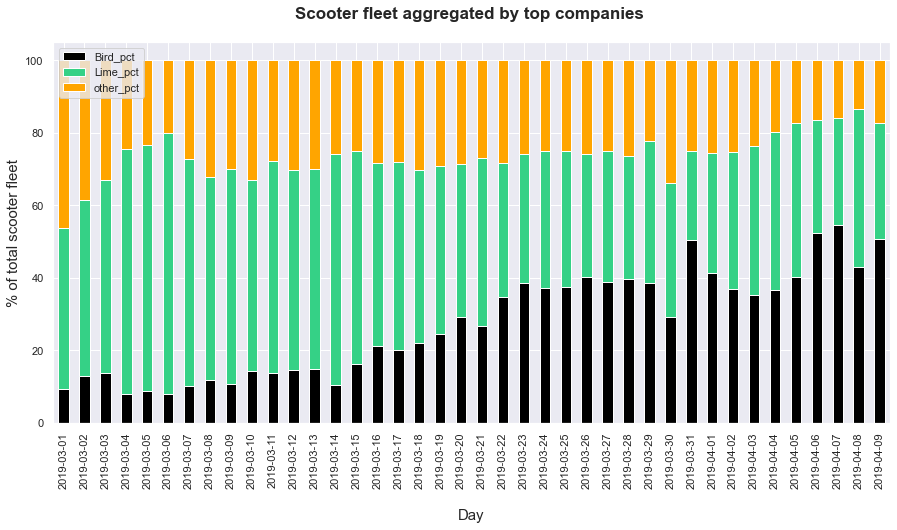

In [30]:
# 100% stacked bar chart
my_colors = 'black', '#35d186','orange'

pivot_supply_pct.loc[:,['Bird_pct','Lime_pct', 'other_pct']].plot.bar(stacked=True, figsize=(15,7), color=my_colors)

plt.xlabel('\nDay', size=15)
plt.ylabel('% of total scooter fleet', size=15)
plt.legend(loc='upper left')

plt.title('Scooter fleet aggregated by top companies \n', fontweight = 'bold', size=17)
plt.show();

In [31]:
# highlight max scooter count per vendor
pivot.style.highlight_max(axis=1)

vendor,Bird,Bolt,Flash,Hive,Lime,Tier,Voi,Wind
dt,,,,,,,,
2019-03-01,442,0,0,0,2106,456,1034,717
2019-03-02,863,0,0,0,3270,727,1144,725
2019-03-03,937,0,0,0,3649,652,1136,471
2019-03-04,798,0,0,0,6940,667,1211,626
2019-03-05,931,0,0,0,7368,645,1223,673
2019-03-06,1008,0,0,0,9146,662,1218,671
2019-03-07,1249,0,0,719,7672,662,1270,696
2019-03-08,1201,0,0,682,5783,653,1166,820
2019-03-09,1211,0,0,720,6692,697,1257,712


In [32]:
# table color coding
cm = sns.light_palette('green', as_cmap=True) 
pivot.style.background_gradient(cmap='summer', axis=1)

vendor,Bird,Bolt,Flash,Hive,Lime,Tier,Voi,Wind
dt,,,,,,,,
2019-03-01,442,0,0,0,2106,456,1034,717
2019-03-02,863,0,0,0,3270,727,1144,725
2019-03-03,937,0,0,0,3649,652,1136,471
2019-03-04,798,0,0,0,6940,667,1211,626
2019-03-05,931,0,0,0,7368,645,1223,673
2019-03-06,1008,0,0,0,9146,662,1218,671
2019-03-07,1249,0,0,719,7672,662,1270,696
2019-03-08,1201,0,0,682,5783,653,1166,820
2019-03-09,1211,0,0,720,6692,697,1257,712


### American scooter companies Lime and Bird took the streets of Paris by storm

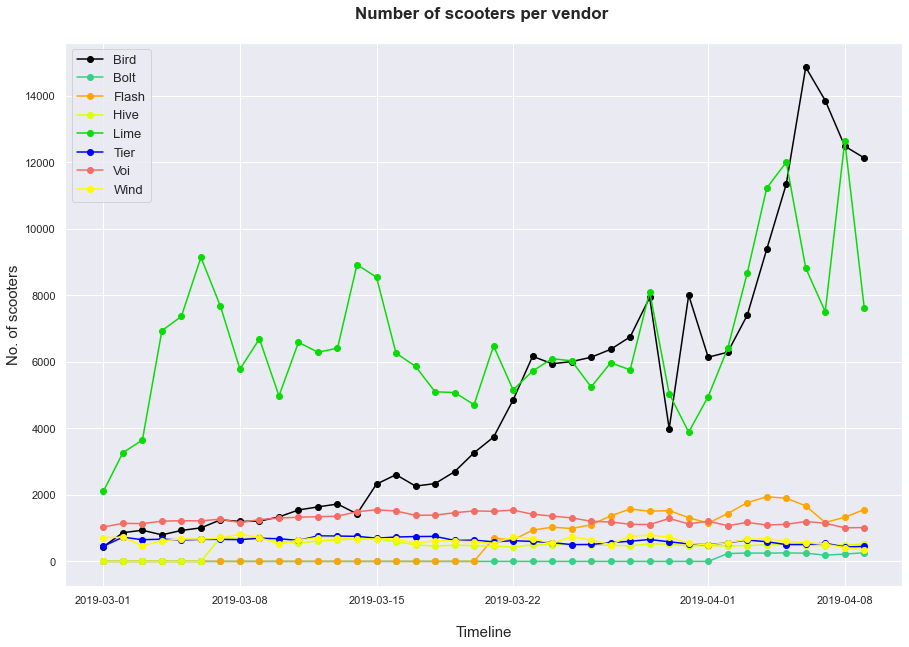

In [33]:
# create a line chart with no. of scooters per vendor in time

plt.figure(figsize=(15,10))

plt.plot(pivot['Bird'], color='black', marker='o')
plt.plot(pivot['Bolt'], color='#35d186', marker='o')
plt.plot(pivot['Flash'], color='orange', marker='o')
plt.plot(pivot['Hive'], color='#dcff00', marker='o')

plt.plot(pivot['Lime'], color='#08dc04', marker='o')
plt.plot(pivot['Tier'], color='blue', marker='o')
plt.plot(pivot['Voi'], color='#f46c64', marker='o')
plt.plot(pivot['Wind'], color='#fffa00', marker='o')

plt.xlabel('\nTimeline', size=15)
plt.ylabel('No. of scooters', size=15)
plt.title('Number of scooters per vendor \n', fontweight='bold', size=17)
plt.legend(['Bird','Bolt','Flash', 'Hive', 'Lime', 'Tier', 'Voi', 'Wind'], loc='upper left', prop={'size': 13})

plt.show()

### The fleet of each of the other market players did not exceed 2k scooters

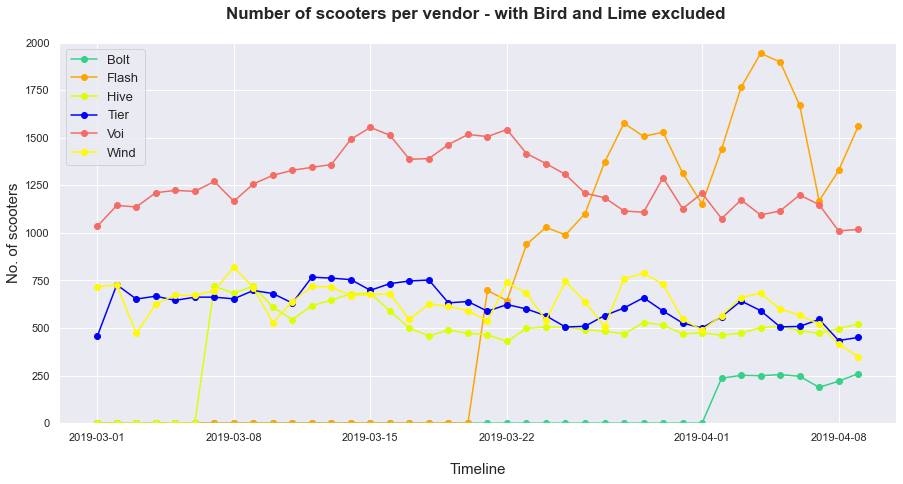

In [34]:
# create a line chart with no. of scooters per vendor in time, two biggest operating companies excluded

plt.figure(figsize=(15,7))

#plt.plot(pivot['Bird'], color='black', marker='o')
plt.plot(pivot['Bolt'], color='#35d186', marker='o')
plt.plot(pivot['Flash'], color='orange', marker='o')
plt.plot(pivot['Hive'], color='#dcff00', marker='o')

#plt.plot(pivot['Lime'], color='#08dc04', marker='o')
plt.plot(pivot['Tier'], color='blue', marker='o')
plt.plot(pivot['Voi'], color='#f46c64', marker='o')
plt.plot(pivot['Wind'], color='#fffa00', marker='o')

plt.xlabel('\nTimeline', size=15)
plt.ylabel('No. of scooters', size=15)
plt.title('Number of scooters per vendor - with Bird and Lime excluded \n', fontweight='bold', size=17)
plt.legend(['Bolt','Flash', 'Hive', 'Tier', 'Voi', 'Wind'], loc='upper left', prop={'size': 13})

plt.ylim(0, 2000)

plt.show()

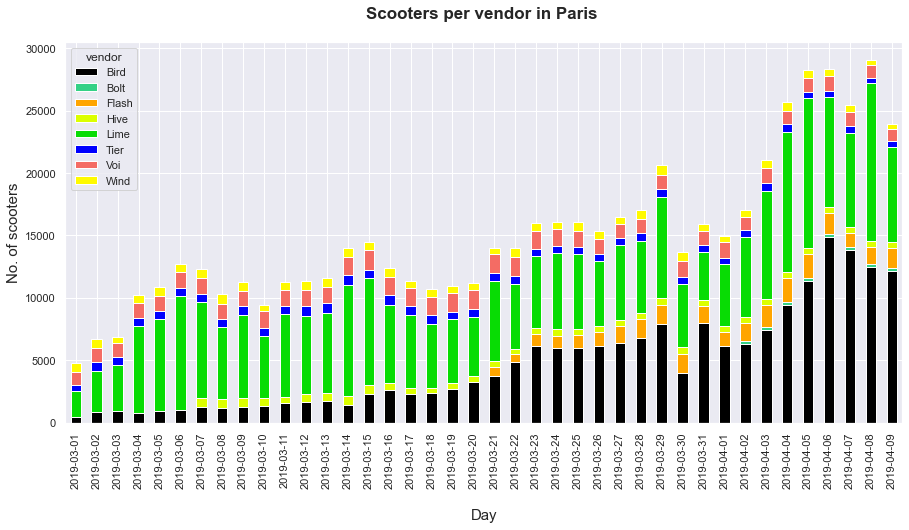

In [35]:
# create a stacked bar chart

my_colors = 'black', '#35d186', 'orange', '#dcff00', '#08dc04', 'blue', '#f46c64', '#fffa00'

pivot.loc[:,['Bird','Bolt', 'Flash', 'Hive', 'Lime', 'Tier', 'Voi', 'Wind']].plot.bar(stacked=True, figsize=(15,7), color=my_colors)

plt.xlabel('\nDay', size=15)
plt.ylabel('No. of scooters', size=15)

plt.title('Scooters per vendor in Paris \n', fontweight = 'bold', size=17)
plt.show()

## 4. Number of rides per vendor

## 4.1. Analyze data for one scooter to better understand the data

In [36]:
# see data for one scooter
pd.set_option('display.max_rows', 509)

example = df[df['scooter_id'] == 'dGllcjpTQ09PVEVSOjE5NjE1']
example.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt
0,2019-04-09 19:03:07.809000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09
1,2019-04-09 18:03:04.599000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09
2,2019-04-09 19:03:01.263000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09
3,2019-04-09 18:03:13.194000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09
4,2019-04-09 18:03:09.912000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900273,2.230193,0,2019-04-09


In [37]:
# sort data for one scooter by time asc
example = example.sort_values(by=['time'])
example.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt
4231658,2019-03-12 06:04:24.889000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900945,2.229721,72,2019-03-12
4442629,2019-03-12 09:01:34.935000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12
7070681,2019-03-12 09:01:44.261000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12
4405184,2019-03-12 09:01:56.794000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12
7100286,2019-03-12 09:01:58.619000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12


### A ride occurred if a scooter changed its location

### The scooter movement is also reflected by a decrease in the battery level and the distance covered

In [38]:
# calculate previous scooter position ('previous_lat' & 'previous_lng'), previous battery level and previous time

example['previous_lat'] = example['lat'].shift(periods=1)
example['previous_lng'] = example['lng'].shift(periods=1)
example['previous_time'] = example['time'].shift(periods=1)
example['previous_battery_level'] = example['battery_level'].shift(periods=1)
example['battery_difference'] = example['battery_level'] - example['previous_battery_level']

# flag rows containing rides

sr = example['previous_lat']
sr2 = example['previous_lng']
example.loc[(((example['lat'] != example['previous_lat']) | (example['lng'] != example['previous_lng']))
             & sr.notnull() & sr2.notnull(),'moved' )] = 'ride'

example.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,moved
4231658,2019-03-12 06:04:24.889000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900945,2.229721,72,2019-03-12,NaN,NaN,NaT,NaN,NaN,NaN
4442629,2019-03-12 09:01:34.935000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.900945,2.229721,2019-03-12 06:04:24.889000+00:00,72.0,-3.0,ride
7070681,2019-03-12 09:01:44.261000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:34.935000+00:00,69.0,0.0,NaN
4405184,2019-03-12 09:01:56.794000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:44.261000+00:00,69.0,0.0,NaN
7100286,2019-03-12 09:01:58.619000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:56.794000+00:00,69.0,0.0,NaN


### We could adapt to specific business requirements and broaden the definition of a ride using the battery_difference field (e.g. a drop of at least 1%)  and the distance field (e.g. at least of 1 km) 

In [39]:
# approximate the ride distance
def haversine_np(lon1, lat1, lon2, lat2):
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

example['distance'] = haversine_np(example['previous_lng'],example['previous_lat'],example['lng'],example['lat'])
example.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,moved,distance
4231658,2019-03-12 06:04:24.889000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900945,2.229721,72,2019-03-12,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4442629,2019-03-12 09:01:34.935000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.900945,2.229721,2019-03-12 06:04:24.889000+00:00,72.0,-3.0,ride,10.100781
7070681,2019-03-12 09:01:44.261000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:34.935000+00:00,69.0,0.0,NaN,0.000000
4405184,2019-03-12 09:01:56.794000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:44.261000+00:00,69.0,0.0,NaN,0.000000
7100286,2019-03-12 09:01:58.619000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:56.794000+00:00,69.0,0.0,NaN,0.000000


### Calculate the number of rides for the sample scooter

In [40]:
# no. of records grouped by movement type - check
example['moved'].value_counts()

ride    83
Name: moved, dtype: int64

In [41]:
# filter out other data than rides
ride_example = example[example['moved'] == 'ride']
ride_example.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,moved,distance
4442629,2019-03-12 09:01:34.935000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.900945,2.229721,2019-03-12 06:04:24.889000+00:00,72.0,-3.0,ride,10.100781
4442326,2019-03-12 12:01:40.744000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845770,2.339791,69,2019-03-12,48.845723,2.339490,2019-03-12 11:02:39.309000+00:00,69.0,0.0,ride,0.022623
4442375,2019-03-12 13:01:27.378000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845941,2.339633,67,2019-03-12,48.845770,2.339791,2019-03-12 12:01:52.453000+00:00,69.0,-2.0,ride,0.022240
4442146,2019-03-12 14:03:07.808000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845768,2.339891,67,2019-03-12,48.845941,2.339633,2019-03-12 13:02:04.904000+00:00,67.0,0.0,ride,0.026936
7100540,2019-03-12 15:02:09.698000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845738,2.340036,66,2019-03-12,48.845768,2.339891,2019-03-12 14:03:30.838000+00:00,67.0,-1.0,ride,0.011116


### Calculate the number of rides for the sample scooter per day

In [42]:
# count no. of daily rides for the sample scooter
pivot_ride_example = pd.pivot_table(ride_example, values='moved', index='dt', columns='scooter_id', aggfunc=pd.Series.count)
pivot_ride_example

scooter_id,dGllcjpTQ09PVEVSOjE5NjE1
dt,
2019-03-12,8
2019-03-13,3
2019-03-14,7
2019-03-15,5
2019-03-17,8
2019-03-18,6
2019-03-22,1
2019-03-23,9
2019-03-24,4


##  4.2. Apply the same approach for all the scooters in the dataset

In [43]:
# sort the data by scooter company name, scooter_id and time to prepare it for the next step
  
df_rides = df.copy()
df_rides.sort_values(by=['vendor', 'scooter_id', 'time'], inplace=True) 

# calculate previous scooter_id column
df_rides['previous_scooter_id'] = df_rides['scooter_id'].shift(periods=1)

# calculate previous scooter position ('previous_lat' & 'previous_lng'), previous battery level and time

df_rides['previous_lat'] = df_rides['lat'].shift(periods=1)
df_rides['previous_lng'] = df_rides['lng'].shift(periods=1)
df_rides['previous_time'] = df_rides['time'].shift(periods=1)
df_rides['previous_battery_level'] = df_rides['battery_level'].shift(periods=1)
df_rides['battery_difference'] = df_rides['battery_level'] - df_rides['previous_battery_level']

# approximate the ride distance
def haversine_np(lon1, lat1, lon2, lat2):
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df_rides['distance'] = haversine_np(df_rides['previous_lng'],df_rides['previous_lat'],df_rides['lng'],df_rides['lat'])

# flag rows containing rides
sr = df_rides['previous_lat']
sr2 = df_rides['previous_lng']
df_rides.loc[( ( (df_rides['lat'] != df_rides['previous_lat']) | (df_rides['lng'] != df_rides['previous_lng']) )
             & sr.notnull() & sr2.notnull() & (df_rides['scooter_id'] == df_rides['previous_scooter_id']),'moved' )] = 'ride'

df_rides.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_scooter_id,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,distance,moved
3884906,2019-03-24 20:01:40.954000+00:00,0001bad0-1b3c-4640-8dcd-d176155bab7b,Bird,48.848770,2.367500,82,2019-03-24,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3867127,2019-03-24 20:01:53.194000+00:00,0001bad0-1b3c-4640-8dcd-d176155bab7b,Bird,48.848770,2.367500,82,2019-03-24,0001bad0-1b3c-4640-8dcd-d176155bab7b,48.848770,2.367500,2019-03-24 20:01:40.954000+00:00,82.0,0.0,0.000000,NaN
3628978,2019-03-24 20:02:01.655000+00:00,0001bad0-1b3c-4640-8dcd-d176155bab7b,Bird,48.848770,2.367500,82,2019-03-24,0001bad0-1b3c-4640-8dcd-d176155bab7b,48.848770,2.367500,2019-03-24 20:01:53.194000+00:00,82.0,0.0,0.000000,NaN
1797998,2019-03-25 07:02:22.722000+00:00,0001bad0-1b3c-4640-8dcd-d176155bab7b,Bird,48.865294,2.310239,100,2019-03-25,0001bad0-1b3c-4640-8dcd-d176155bab7b,48.848770,2.367500,2019-03-24 20:02:01.655000+00:00,82.0,18.0,4.571548,ride
1794801,2019-03-25 07:02:57.773000+00:00,0001bad0-1b3c-4640-8dcd-d176155bab7b,Bird,48.865294,2.310239,100,2019-03-25,0001bad0-1b3c-4640-8dcd-d176155bab7b,48.865294,2.310239,2019-03-25 07:02:22.722000+00:00,100.0,0.0,0.000000,NaN


In [44]:
# count all rows with rides
df_rides['moved'].value_counts()

ride    1936318
Name: moved, dtype: int64

## 4.3. Calculate the number of rides per vendor

In [45]:
# filter out other data than rides
rides = df_rides[df_rides['moved'] == 'ride']
rides['vendor'].value_counts()
# lack of data for Lime

Bird     753045
Voi      333064
Flash    319222
Wind     204721
Tier     161797
Hive     149353
Bolt      15116
Name: vendor, dtype: int64

### Since March 20, Bird is the market leader

In [46]:
# count no. of daily rides per vendor
pivot_rides = pd.pivot_table(rides, values='moved', index='dt', columns='vendor', aggfunc=pd.Series.count, fill_value=0)
pivot_rides['TOTAL'] = pivot_rides.sum(axis=1)
pivot_rides.style.background_gradient(cmap='summer', axis=1)

vendor,Bird,Bolt,Flash,Hive,Tier,Voi,Wind,TOTAL
dt,,,,,,,,
2019-03-01,363,0,0,0,729,1402,1403,3897
2019-03-02,1560,0,0,0,4365,4227,3587,13739
2019-03-03,2099,0,0,0,3590,4435,1878,12002
2019-03-04,4705,0,0,0,5945,6845,3253,20748
2019-03-05,4690,0,0,0,5785,6698,4214,21387
2019-03-06,4290,0,0,0,5605,7185,3543,20623
2019-03-07,5619,0,0,4675,6106,7366,1519,25285
2019-03-08,3454,0,0,6962,3886,6881,1759,22942
2019-03-09,3279,0,0,4805,3035,6691,1925,19735


## 4.4. Lime ride data imputation

In [47]:
# first look at the Lime ride data
lime = df_rides[df_rides['vendor'] == 'Lime']
lime.sort_values(by=['scooter_id', 'time'])
pd.set_option('display.max_rows', 1000)
lime.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_scooter_id,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,distance,moved
7036632,2019-03-15 17:02:26.767000+00:00,ET-2225OMX22NTZRK4KRMIYTD4X67YRLYXSFJP2HBI,Lime,48.831940,2.388478,60,2019-03-15,aGl2ZTpTQ09PVEVSOjEzNTkz,48.873736,2.296590,2019-04-09 22:02:09.846000+00:00,39.0,21.0,8.167917,NaN
3064033,2019-03-01 13:24:43.827000+00:00,ET-222DGHN355TSFPBDCUVUIR2AFE7O5W4IK2RYWJQ,Lime,48.871765,2.372235,10,2019-03-01,ET-2225OMX22NTZRK4KRMIYTD4X67YRLYXSFJP2HBI,48.831940,2.388478,2019-03-15 17:02:26.767000+00:00,60.0,-50.0,4.582162,NaN
6574657,2019-04-09 09:02:46.780000+00:00,ET-222EBS5B5RI7RCFLGDSHAJWDYIG6VWH2X57VPBY,Lime,48.851476,2.384640,100,2019-04-09,ET-222DGHN355TSFPBDCUVUIR2AFE7O5W4IK2RYWJQ,48.871765,2.372235,2019-03-01 13:24:43.827000+00:00,10.0,90.0,2.430175,NaN
795218,2019-03-20 02:02:15.995000+00:00,ET-222GIB2ZJG7HCWNZRWNPXD72OINYONF2QX4JCHQ,Lime,48.863586,2.388014,100,2019-03-20,ET-222EBS5B5RI7RCFLGDSHAJWDYIG6VWH2X57VPBY,48.851476,2.384640,2019-04-09 09:02:46.780000+00:00,100.0,0.0,1.368148,NaN
5529326,2019-04-07 12:02:45.026000+00:00,ET-222PK74SCJBPEV5EQHYJAP5RSWI4Z5DLX5ME3ZI,Lime,48.869552,2.373894,100,2019-04-07,ET-222GIB2ZJG7HCWNZRWNPXD72OINYONF2QX4JCHQ,48.863586,2.388014,2019-03-20 02:02:15.995000+00:00,100.0,0.0,1.226745,NaN


In [48]:
# sort the Lime ride date by time and scooter_id
lime2 = df[df['vendor'] == 'Lime']
lime2.sort_values(by=['time', 'scooter_id'])

,time,scooter_id,vendor,lat,lng,battery_level,dt
5996856,2019-03-01 00:00:12.654000+00:00,ET-XU3XNU22Q23PAEJAUB3FRWJABPPWRYZNA3GXZ7Y,Lime,48.889001,2.298331,10,2019-03-01
5996825,2019-03-01 01:00:17.050000+00:00,ET-7DAOPSNZQT2TK65FF3JYWD4ZMWPEHKQVV3T46KQ,Lime,48.889001,2.298331,10,2019-03-01
5996864,2019-03-01 05:00:20.749000+00:00,ET-74UP4HJ4G2HPVYL544CWFMFP6GYOEWECD5QGXDQ,Lime,48.885131,2.296018,10,2019-03-01
5996858,2019-03-01 05:00:20.749000+00:00,ET-CKJXATG6ZPTM2UOVFELS64Q3NXBUHL2FCEZGWLQ,Lime,48.888428,2.294025,10,2019-03-01
5996871,2019-03-01 05:00:20.749000+00:00,ET-DGP7SJQMIEXAVNUEYDKKQWHB4I4AUAI2HOADIGI,Lime,48.886597,2.296000,10,2019-03-01
...,...,...,...,...,...,...,...
72479,2019-04-09 23:02:46.283000+00:00,ET-OBLHBU5VWWF2QNVB33LQX37OKTD25C67PJEW5BA,Lime,48.898926,2.223333,100,2019-04-09
72551,2019-04-09 23:02:46.283000+00:00,ET-QTNA6KY2KS7LIKX5XCXNNQ7BIXRYPJPQS3CFKWI,Lime,48.899052,2.223377,100,2019-04-09
72661,2019-04-09 23:02:46.283000+00:00,ET-URKLDIFRGSL24DW6G66WDFCLH6D6KG65K7WOK3Y,Lime,48.898839,2.223496,100,2019-04-09
72677,2019-04-09 23:02:46.283000+00:00,ET-VFGKXNSU2KANGLHEZQHDVD6ON3XJWQ6RRCH556I,Lime,48.898847,2.223445,100,2019-04-09


In [49]:
# Lime data - no. of records per scooter
lime2['scooter_id'].value_counts()

ET-BTBTDJQYGFPOUB4U7ZL45UB33MMRHWQF2UJKTRY    2
ET-DRBUIK2QMDNYWTMR6SDRQUPCTT3MPHNO4ZWOGOQ    2
ET-7O2UCX3PNRSJW5WPMG4LH5GIVYYC2Q2MLNKPBDQ    2
ET-NRXFBA3BX5E64X4E4LEAJWYX3PSBIM52XFHQR6A    2
ET-KAPANQRPGPYRFZREHXU3KLEND27PBV6CBJDHOXI    2
                                             ..
ET-OJVNDNEAZGH372TVABWBSWHHGPCCBUWIKYYQRDQ    1
ET-G5RH3LEATWEIR6OVOALGSI4VQINRUTIAYQKUCVA    1
ET-5EHFGOC47V3H5LR33V2ZAMQBLAPBEDIKREQP7WY    1
ET-4QBA5XZN7RCDIQCVS5JE5UTG4JZW32FUHOQSYJY    1
ET-GPRZPPQ5OSJ4ZVZVY7HGEMPYSP2Y4U77YAXF2LI    1
Name: scooter_id, Length: 264733, dtype: int64

In [50]:
# Lime scooter example data check
check = df[df['scooter_id'] == 'ET-4OCMJ6KVHW3KKFWGFLUCTBFIV2EDJH2TSM6VNOY']
check

,time,scooter_id,vendor,lat,lng,battery_level,dt
4644224,2019-04-05 16:02:40.678000+00:00,ET-4OCMJ6KVHW3KKFWGFLUCTBFIV2EDJH2TSM6VNOY,Lime,48.858231,2.351887,10,2019-04-05
4645278,2019-04-05 16:03:48.526000+00:00,ET-4OCMJ6KVHW3KKFWGFLUCTBFIV2EDJH2TSM6VNOY,Lime,48.858231,2.351887,10,2019-04-05


In [51]:
# Lime scooter example data check
check2 = df[df['scooter_id'] == 'ET-UH3UQ2YGFW4SJAJPPYRSU6XQEOJALP65FAGBCRY']
check2

,time,scooter_id,vendor,lat,lng,battery_level,dt
2888871,2019-03-01 13:31:34.112000+00:00,ET-UH3UQ2YGFW4SJAJPPYRSU6XQEOJALP65FAGBCRY,Lime,48.898287,2.371897,10,2019-03-01
2888874,2019-03-01 13:29:56.153000+00:00,ET-UH3UQ2YGFW4SJAJPPYRSU6XQEOJALP65FAGBCRY,Lime,48.898287,2.371897,10,2019-03-01


In [52]:
# Lime scooter example data check
check3 = df[df['scooter_id'] == 'ET-CFYJDPWNYNVANOZI3C3RYSHMNOXYH2FBA5JXPHA']
check3

,time,scooter_id,vendor,lat,lng,battery_level,dt
5997241,2019-03-01 13:31:14.013000+00:00,ET-CFYJDPWNYNVANOZI3C3RYSHMNOXYH2FBA5JXPHA,Lime,48.881788,2.30286,10,2019-03-01
5997365,2019-03-01 13:29:54.791000+00:00,ET-CFYJDPWNYNVANOZI3C3RYSHMNOXYH2FBA5JXPHA,Lime,48.881788,2.30286,10,2019-03-01


In [53]:
# check using previous scooter example
check = rides[rides['scooter_id'] == 'dGllcjpTQ09PVEVSOjE5NjE1']
check.sort_values(by=['time'])
check.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_scooter_id,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,distance,moved
4442629,2019-03-12 09:01:34.935000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,dGllcjpTQ09PVEVSOjE5NjE1,48.900945,2.229721,2019-03-12 06:04:24.889000+00:00,72.0,-3.0,10.100781,ride
4442326,2019-03-12 12:01:40.744000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845770,2.339791,69,2019-03-12,dGllcjpTQ09PVEVSOjE5NjE1,48.845723,2.339490,2019-03-12 11:02:39.309000+00:00,69.0,0.0,0.022623,ride
4442375,2019-03-12 13:01:27.378000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845941,2.339633,67,2019-03-12,dGllcjpTQ09PVEVSOjE5NjE1,48.845770,2.339791,2019-03-12 12:01:52.453000+00:00,69.0,-2.0,0.022240,ride
4442146,2019-03-12 14:03:07.808000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845768,2.339891,67,2019-03-12,dGllcjpTQ09PVEVSOjE5NjE1,48.845941,2.339633,2019-03-12 13:02:04.904000+00:00,67.0,0.0,0.026936,ride
7100540,2019-03-12 15:02:09.698000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845738,2.340036,66,2019-03-12,dGllcjpTQ09PVEVSOjE5NjE1,48.845768,2.339891,2019-03-12 14:03:30.838000+00:00,67.0,-1.0,0.011116,ride


### We can estimate the number of rides for Lime by comparing the size of the fleet for Bird and Lime

In [54]:
# create a pivot table with the fleet size comparison for Bird and Lime
lime_bird_ratio = df.pivot_table(values='scooter_id', index='dt', columns='vendor', aggfunc=pd.Series.nunique, fill_value=0)
lime_bird_ratio['Ratio'] = lime_bird_ratio['Lime']/lime_bird_ratio['Bird']
lime_bird_ratio[['Bird', 'Lime', 'Ratio']]

vendor,Bird,Lime,Ratio
dt,,,
2019-03-01,442,2106,4.764706
2019-03-02,863,3270,3.789108
2019-03-03,937,3649,3.894344
2019-03-04,798,6940,8.696742
2019-03-05,931,7368,7.914071
2019-03-06,1008,9146,9.073413
2019-03-07,1249,7672,6.142514
2019-03-08,1201,5783,4.815154
2019-03-09,1211,6692,5.526012


In [55]:
# show Bird rides as a separate dataframe
bird_rides = pivot_rides['Bird']
birdrides = bird_rides.to_frame()
birdrides.columns =['Bird_rides']
birdrides

,Bird_rides
dt,
2019-03-01,363
2019-03-02,1560
2019-03-03,2099
2019-03-04,4705
2019-03-05,4690
2019-03-06,4290
2019-03-07,5619
2019-03-08,3454
2019-03-09,3279


### Lime ride data estimated

In [56]:
# join the dataframe with the fleet size comparison for Bird and Lime with the Bird rides dataframe
limerides = pd.merge(lime_bird_ratio[['Bird', 'Lime', 'Ratio']], birdrides, how = 'outer', on = 'dt')
limerides['Lime_rides_estimate'] = round(limerides['Bird_rides']*limerides['Ratio'],0)
limerides

,Bird,Lime,Ratio,Bird_rides,Lime_rides_estimate
dt,,,,,
2019-03-01,442,2106,4.764706,363,1730.0
2019-03-02,863,3270,3.789108,1560,5911.0
2019-03-03,937,3649,3.894344,2099,8174.0
2019-03-04,798,6940,8.696742,4705,40918.0
2019-03-05,931,7368,7.914071,4690,37117.0
2019-03-06,1008,9146,9.073413,4290,38925.0
2019-03-07,1249,7672,6.142514,5619,34515.0
2019-03-08,1201,5783,4.815154,3454,16632.0
2019-03-09,1211,6692,5.526012,3279,18120.0


In [57]:
# join the dataframe with the daily rides per vendor withe the estimation for Lime
all_rides = pd.merge(pivot_rides[['Bird', 'Bolt','Flash','Hive','Tier','Voi','Wind']], limerides['Lime_rides_estimate'], how = 'outer', on = 'dt')
all_rides['TOTAL'] = all_rides.sum(axis=1).apply('{0:g}'.format)
all_rides['Lime_rides_estimate'] = all_rides['Lime_rides_estimate'].apply('{0:g}'.format)
all_rides

,Bird,Bolt,Flash,Hive,Tier,Voi,Wind,Lime_rides_estimate,TOTAL
dt,,,,,,,,,
2019-03-01,363,0,0,0,729,1402,1403,1730,5627
2019-03-02,1560,0,0,0,4365,4227,3587,5911,19650
2019-03-03,2099,0,0,0,3590,4435,1878,8174,20176
2019-03-04,4705,0,0,0,5945,6845,3253,40918,61666
2019-03-05,4690,0,0,0,5785,6698,4214,37117,58504
2019-03-06,4290,0,0,0,5605,7185,3543,38925,59548
2019-03-07,5619,0,0,4675,6106,7366,1519,34515,59800
2019-03-08,3454,0,0,6962,3886,6881,1759,16632,39574
2019-03-09,3279,0,0,4805,3035,6691,1925,18120,37855


## 5. Scooter utilization

## 5.1 Daily active scooter fleet per vendor

### The active scooter fleet for Bird grew exponentially with each passing day

In [58]:
# count no. of utilized scooters per vendor
pivot_utilized_scooters = pd.pivot_table(rides, values='scooter_id', index='dt', columns='vendor', aggfunc=pd.Series.nunique, fill_value=0)
pivot_utilized_scooters['TOTAL'] = pivot_utilized_scooters['Bird'] + pivot_utilized_scooters['Bolt'] + pivot_utilized_scooters['Flash'] + pivot_utilized_scooters['Hive'] + pivot_utilized_scooters['Tier'] + pivot_utilized_scooters['Voi'] + pivot_utilized_scooters['Wind']
pivot_utilized_scooters.style.background_gradient(cmap='summer', axis=1)

vendor,Bird,Bolt,Flash,Hive,Tier,Voi,Wind,TOTAL
dt,,,,,,,,
2019-03-01,217,0,0,0,345,661,623,1846
2019-03-02,495,0,0,0,719,1025,684,2923
2019-03-03,583,0,0,0,645,1004,424,2656
2019-03-04,618,0,0,0,661,1007,576,2862
2019-03-05,712,0,0,0,639,1045,640,3036
2019-03-06,712,0,0,0,654,1038,614,3018
2019-03-07,985,0,0,711,656,1099,631,4082
2019-03-08,907,0,0,679,626,1047,687,3946
2019-03-09,822,0,0,695,672,1105,592,3886


## 5.2. Hourly fleet utilization ratio

In [59]:
# most recent full data is from April, 8th
df_rides['date'] = pd.to_datetime(df_rides['dt']) 
df_rides['hour']= pd.to_datetime(df_rides['time'])
df_rides['hour'] = df_rides['time'].dt.hour

last_day = df_rides.loc[df_rides['date'] == '2019-04-08']
last_day.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_scooter_id,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,distance,moved,date,hour
6419680,2019-04-08 11:02:39.383000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,00025268-82fe-47f2-8cfc-c77897555c35,48.874092,2.316005,2019-03-29 19:03:19.898000+00:00,98.0,2.0,1.703261,NaN,2019-04-08,11
6676596,2019-04-08 11:02:43.940000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:39.383000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11
6427311,2019-04-08 11:03:00.961000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:43.940000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11
6427235,2019-04-08 12:02:32.076000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:03:00.961000+00:00,100.0,0.0,0.004727,ride,2019-04-08,12
6676047,2019-04-08 12:02:41.024000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869543,2.293749,2019-04-08 12:02:32.076000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,12


In [60]:
# total hourly fleet available per vendor
hourly_fleet = pd.pivot_table(last_day, values='scooter_id', index='hour', columns='vendor', aggfunc=pd.Series.nunique, fill_value=0)
hourly_fleet

vendor,Bird,Bolt,Flash,Hive,Lime,Tier,Voi,Wind
hour,,,,,,,,
0,0,25,425,253,283,127,507,276
1,0,26,475,253,392,128,499,271
2,86,26,535,254,194,173,497,309
3,1514,26,533,313,525,213,496,321
4,2872,89,586,342,744,282,759,343
5,3827,140,742,384,784,387,813,351
6,3617,131,892,355,357,385,713,260
7,3635,156,961,378,705,408,749,257
8,3651,164,929,389,417,386,726,307


In [61]:
# number of scooters active within a specified hour per vendor
last_day_moved = last_day.loc[last_day['moved'] == 'ride']

no_of_scooters = pd.pivot_table(last_day_moved, values='scooter_id', index='hour', columns='vendor', aggfunc=pd.Series.nunique, fill_value=0)
no_of_scooters

vendor,Bird,Bolt,Flash,Hive,Tier,Voi,Wind
hour,,,,,,,
0,0,10,304,97,25,127,233
1,0,4,310,98,14,107,226
2,60,5,348,93,56,106,266
3,1017,8,344,131,95,123,264
4,2289,71,430,128,118,286,283
5,3293,64,584,148,175,251,285
6,3366,24,770,152,155,202,219
7,3226,84,799,163,143,276,218
8,3131,109,835,182,174,254,251


### On April 8, hourly fleet utilization remained consistently high all day long for Wind
### In general, the highest utilization was achieved in the morning and the afternoon rush hours

In [62]:
# hourly fleet utilization ratio calculation 
# hourly fleet utilization ratio per vendor = no. of scooter active within a specified hour per vendor / total hourly fleet available for a vendor
hourly_utilization = pd.merge(no_of_scooters, hourly_fleet, how = 'outer', on = 'hour')
hourly_utilization['Bird'] = round(hourly_utilization['Bird_x'] * 100 / hourly_utilization['Bird_y'],2)
hourly_utilization['Bolt'] = round(hourly_utilization['Bolt_x'] * 100 / hourly_utilization['Bolt_y'],2)
hourly_utilization['Flash'] = round(hourly_utilization['Flash_x'] * 100 / hourly_utilization['Flash_y'],2)
hourly_utilization['Hive'] = round(hourly_utilization['Hive_x'] * 100 / hourly_utilization['Hive_y'],2)
hourly_utilization['Tier'] = round(hourly_utilization['Tier_x'] * 100 / hourly_utilization['Tier_y'],2)
hourly_utilization['Voi'] = round(hourly_utilization['Voi_x'] * 100 / hourly_utilization['Voi_y'],2)
hourly_utilization['Wind'] = round(hourly_utilization['Wind_x'] * 100 / hourly_utilization['Wind_y'],2)
hourly_utilization = hourly_utilization[['Bird','Bolt','Flash','Hive','Tier','Voi','Wind']]
hourly_utilization.fillna(0).style.background_gradient(cmap='coolwarm', axis=1)

vendor,Bird,Bolt,Flash,Hive,Tier,Voi,Wind
hour,,,,,,,
0,0.000000,40.000000,71.530000,38.340000,19.690000,25.050000,84.420000
1,0.000000,15.380000,65.260000,38.740000,10.940000,21.440000,83.390000
2,69.770000,19.230000,65.050000,36.610000,32.370000,21.330000,86.080000
3,67.170000,30.770000,64.540000,41.850000,44.600000,24.800000,82.240000
4,79.700000,79.780000,73.380000,37.430000,41.840000,37.680000,82.510000
5,86.050000,45.710000,78.710000,38.540000,45.220000,30.870000,81.200000
6,93.060000,18.320000,86.320000,42.820000,40.260000,28.330000,84.230000
7,88.750000,53.850000,83.140000,43.120000,35.050000,36.850000,84.820000
8,85.760000,66.460000,89.880000,46.790000,45.080000,34.990000,81.760000


## 5.3. Daily fleet utilization ratio

In [63]:
# total daily fleet available per vendor
daily_fleet = pd.pivot_table(last_day, values='scooter_id', index='dt', columns='vendor', aggfunc=pd.Series.nunique, fill_value=0)
daily_fleet

vendor,Bird,Bolt,Flash,Hive,Lime,Tier,Voi,Wind
dt,,,,,,,,
2019-04-08,12487,220,1328,497,12644,434,1010,415


In [64]:
# number of scooters active within a specified hour per vendor
no_of_scooters

vendor,Bird,Bolt,Flash,Hive,Tier,Voi,Wind
hour,,,,,,,
0,0,10,304,97,25,127,233
1,0,4,310,98,14,107,226
2,60,5,348,93,56,106,266
3,1017,8,344,131,95,123,264
4,2289,71,430,128,118,286,283
5,3293,64,584,148,175,251,285
6,3366,24,770,152,155,202,219
7,3226,84,799,163,143,276,218
8,3131,109,835,182,174,254,251


### None of the companies utilized at any time more than 70% of its total fleet available on the given day

In [65]:
# total daily fleet available per vendor
no_of_scooters['Bird_daily_fleet'] = 12487
no_of_scooters['Bolt_daily_fleet'] = 220
no_of_scooters['Flash_daily_fleet'] = 1328
no_of_scooters['Hive_daily_fleet'] = 497
no_of_scooters['Tier_daily_fleet'] = 434
no_of_scooters['Voi_daily_fleet'] = 1010
no_of_scooters['Wind_daily_fleet'] = 415

# daily fleet utilization ratio calculation
# daily fleet utilization ratio per vendor = no. of scooter active within a specified hour per vendor / total daily fleet available for a vendor
no_of_scooters['Bird_df'] = round(no_of_scooters['Bird'] * 100 / no_of_scooters['Bird_daily_fleet'],2)
no_of_scooters['Bolt_df'] = round(no_of_scooters['Bolt'] * 100 / no_of_scooters['Bolt_daily_fleet'],2)
no_of_scooters['Flash_df'] = round(no_of_scooters['Flash'] * 100 / no_of_scooters['Flash_daily_fleet'],2)
no_of_scooters['Hive_df'] = round(no_of_scooters['Hive'] * 100 / no_of_scooters['Hive_daily_fleet'],2)
no_of_scooters['Tier_df'] = round(no_of_scooters['Tier'] * 100 / no_of_scooters['Tier_daily_fleet'],2)
no_of_scooters['Voi_df'] = round(no_of_scooters['Voi'] * 100 / no_of_scooters['Voi_daily_fleet'],2)
no_of_scooters['Wind_df'] = round(no_of_scooters['Wind'] * 100 / no_of_scooters['Wind_daily_fleet'],2)
no_of_scooters = no_of_scooters[['Bird_df','Bolt_df','Flash_df','Hive_df','Tier_df','Voi_df','Wind_df']]
no_of_scooters.fillna(0).style.background_gradient(cmap='Blues', axis=1)

vendor,Bird_df,Bolt_df,Flash_df,Hive_df,Tier_df,Voi_df,Wind_df
hour,,,,,,,
0,0.000000,4.550000,22.890000,19.520000,5.760000,12.570000,56.140000
1,0.000000,1.820000,23.340000,19.720000,3.230000,10.590000,54.460000
2,0.480000,2.270000,26.200000,18.710000,12.900000,10.500000,64.100000
3,8.140000,3.640000,25.900000,26.360000,21.890000,12.180000,63.610000
4,18.330000,32.270000,32.380000,25.750000,27.190000,28.320000,68.190000
5,26.370000,29.090000,43.980000,29.780000,40.320000,24.850000,68.670000
6,26.960000,10.910000,57.980000,30.580000,35.710000,20.000000,52.770000
7,25.830000,38.180000,60.170000,32.800000,32.950000,27.330000,52.530000
8,25.070000,49.550000,62.880000,36.620000,40.090000,25.150000,60.480000


## 6. Integrating geospatial data into the analysis

## 6.1. A point-in-polygon problem

### Shapefiles can be used for area delimitation

In [66]:
# open the shapefile with a list of neighbourhoods
# apply encoding for the French characters
df_neighbourhoods = gpd.read_file('arrondissements.shp', encoding='utf-8')
df_neighbourhoods.head()

,n_sq_ar,c_ar,c_arinsee,l_ar,l_aroff,n_sq_co,surface,perimetre,objectid,longueur,geometry
0,750000001.0,1.0,75101.0,1er Ardt,Louvre,750001537.0,1.824613e+06,6054.936862,1.0,6054.680862,"POLYGON ((2.32801 48.86992, 2.32997 48.86851, ..."
1,750000007.0,7.0,75107.0,7ème Ardt,Palais-Bourbon,750001537.0,4.090057e+06,8099.424883,7.0,8099.033151,"POLYGON ((2.32090 48.86306, 2.32094 48.86305, ..."
2,750000002.0,2.0,75102.0,2ème Ardt,Bourse,750001537.0,9.911537e+05,4554.104360,2.0,4553.938764,"POLYGON ((2.35152 48.86443, 2.35095 48.86341, ..."
3,750000017.0,17.0,75117.0,17ème Ardt,Batignolles-Monceau,750001537.0,5.668835e+06,10775.579516,17.0,10775.348915,"POLYGON ((2.29517 48.87396, 2.29504 48.87378, ..."
4,750000004.0,4.0,75104.0,4ème Ardt,Hôtel-de-Ville,750001537.0,1.600586e+06,5420.908434,4.0,5420.636779,"POLYGON ((2.36851 48.85573, 2.36900 48.85374, ..."


### There are twenty administrative districts called 'arrondissements' in Paris

In [67]:
# list all neighbourhoods in Paris
df_neighbourhoods[['c_ar', 'l_ar','l_aroff']].sort_values(by=['c_ar'])

,c_ar,l_ar,l_aroff
0,1.0,1er Ardt,Louvre
2,2.0,2ème Ardt,Bourse
13,3.0,3ème Ardt,Temple
4,4.0,4ème Ardt,Hôtel-de-Ville
17,5.0,5ème Ardt,Panthéon
18,6.0,6ème Ardt,Luxembourg
1,7.0,7ème Ardt,Palais-Bourbon
5,8.0,8ème Ardt,Élysée
7,9.0,9ème Ardt,Opéra
11,10.0,10ème Ardt,Entrepôt


In [68]:
# return the exterior coordinates as a list
df_neighbourhoods['geomlist'] = df_neighbourhoods['geometry'].apply(lambda x: list(x.exterior.coords))
df_neighbourhoods.head()

,n_sq_ar,c_ar,c_arinsee,l_ar,l_aroff,n_sq_co,surface,perimetre,objectid,longueur,geometry,geomlist
0,750000001.0,1.0,75101.0,1er Ardt,Louvre,750001537.0,1.824613e+06,6054.936862,1.0,6054.680862,"POLYGON ((2.32801 48.86992, 2.32997 48.86851, ...","[(2.328007329038849, 48.86991742140716), (2.32..."
1,750000007.0,7.0,75107.0,7ème Ardt,Palais-Bourbon,750001537.0,4.090057e+06,8099.424883,7.0,8099.033151,"POLYGON ((2.32090 48.86306, 2.32094 48.86305, ...","[(2.320902853673183, 48.863057390616895), (2.3..."
2,750000002.0,2.0,75102.0,2ème Ardt,Bourse,750001537.0,9.911537e+05,4554.104360,2.0,4553.938764,"POLYGON ((2.35152 48.86443, 2.35095 48.86341, ...","[(2.351518483670822, 48.8644258050741), (2.350..."
3,750000017.0,17.0,75117.0,17ème Ardt,Batignolles-Monceau,750001537.0,5.668835e+06,10775.579516,17.0,10775.348915,"POLYGON ((2.29517 48.87396, 2.29504 48.87378, ...","[(2.295166912564455, 48.873955232398906), (2.2..."
4,750000004.0,4.0,75104.0,4ème Ardt,Hôtel-de-Ville,750001537.0,1.600586e+06,5420.908434,4.0,5420.636779,"POLYGON ((2.36851 48.85573, 2.36900 48.85374, ...","[(2.368512371393433, 48.85573412813671), (2.36..."


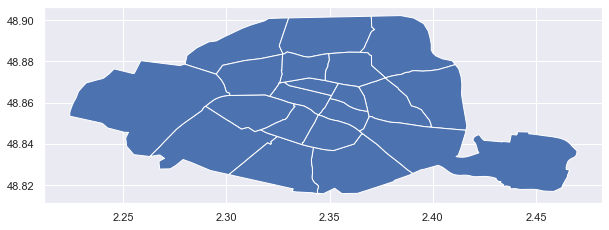

In [69]:
# plot all neighbourhoods
df_neighbourhoods.plot(figsize=(10, 10));

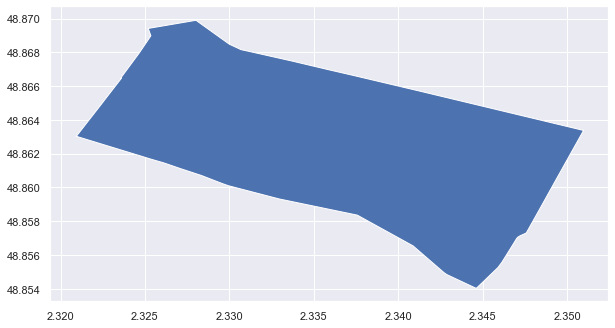

In [70]:
# check out the Louvre neighbourhood
louvre = df_neighbourhoods.loc[df_neighbourhoods['l_aroff']=='Louvre']
louvre.plot(figsize=(10, 10));

In [71]:
# create a function for determining if a point lies inside the shape boundary
def point_inside_polygon(lat,lng,poly):
    n = len(poly)
    inside =False
    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if lat > min(p1y,p2y):
            if lat <= max(p1y,p2y):
                if lng <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (lat-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or lng <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y
    return inside

In [72]:
# create a function for determining neighbourhood area
def get_neighbourhood(row):
    for ix, area in df_neighbourhoods.iterrows():
        is_in_area=False
        if row['lat'] and row['lng']:
            is_in_area = point_inside_polygon(row['lat'], row['lng'], area['geomlist'])
            if is_in_area:
                #found area, exit
                return area['l_aroff']
    return ""
example['neighbourhood'] = example.apply(lambda row: get_neighbourhood(row), axis=1)

In [73]:
example.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,moved,distance,neighbourhood
4231658,2019-03-12 06:04:24.889000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900945,2.229721,72,2019-03-12,NaN,NaN,NaT,NaN,NaN,NaN,NaN,
4442629,2019-03-12 09:01:34.935000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.900945,2.229721,2019-03-12 06:04:24.889000+00:00,72.0,-3.0,ride,10.100781,Luxembourg
7070681,2019-03-12 09:01:44.261000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:34.935000+00:00,69.0,0.0,NaN,0.000000,Luxembourg
4405184,2019-03-12 09:01:56.794000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:44.261000+00:00,69.0,0.0,NaN,0.000000,Luxembourg
7100286,2019-03-12 09:01:58.619000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:56.794000+00:00,69.0,0.0,NaN,0.000000,Luxembourg


In [74]:
example['previous_neighbourhood'] = example['neighbourhood'].shift(periods=1)
example.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,moved,distance,neighbourhood,previous_neighbourhood
4231658,2019-03-12 06:04:24.889000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.900945,2.229721,72,2019-03-12,NaN,NaN,NaT,NaN,NaN,NaN,NaN,,NaN
4442629,2019-03-12 09:01:34.935000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.900945,2.229721,2019-03-12 06:04:24.889000+00:00,72.0,-3.0,ride,10.100781,Luxembourg,
7070681,2019-03-12 09:01:44.261000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:34.935000+00:00,69.0,0.0,NaN,0.000000,Luxembourg,Luxembourg
4405184,2019-03-12 09:01:56.794000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:44.261000+00:00,69.0,0.0,NaN,0.000000,Luxembourg,Luxembourg
7100286,2019-03-12 09:01:58.619000+00:00,dGllcjpTQ09PVEVSOjE5NjE1,Tier,48.845723,2.339490,69,2019-03-12,48.845723,2.339490,2019-03-12 09:01:56.794000+00:00,69.0,0.0,NaN,0.000000,Luxembourg,Luxembourg


## 6.2. The most interesting areas in Paris to deploy scooters in

In [75]:
# filter out April data
df_rides['date']= pd.to_datetime(df_rides['dt']) 

april = df_rides.loc[df_rides['date'] >= '2019-04-01']
april.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_scooter_id,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,distance,moved,date,hour
6419680,2019-04-08 11:02:39.383000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,00025268-82fe-47f2-8cfc-c77897555c35,48.874092,2.316005,2019-03-29 19:03:19.898000+00:00,98.0,2.0,1.703261,NaN,2019-04-08,11
6676596,2019-04-08 11:02:43.940000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:39.383000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11
6427311,2019-04-08 11:03:00.961000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:43.940000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11
6427235,2019-04-08 12:02:32.076000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:03:00.961000+00:00,100.0,0.0,0.004727,ride,2019-04-08,12
6676047,2019-04-08 12:02:41.024000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869543,2.293749,2019-04-08 12:02:32.076000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,12


In [76]:
# add neighbourhood column
april['neighbourhood'] = april.apply(lambda row: get_neighbourhood(row), axis=1)
april.head()

<ipython-input-76-026272d29ee8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  april['neighbourhood'] = april.apply(lambda row: get_neighbourhood(row), axis=1)


,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_scooter_id,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,distance,moved,date,hour,neighbourhood
6419680,2019-04-08 11:02:39.383000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,00025268-82fe-47f2-8cfc-c77897555c35,48.874092,2.316005,2019-03-29 19:03:19.898000+00:00,98.0,2.0,1.703261,NaN,2019-04-08,11,Passy
6676596,2019-04-08 11:02:43.940000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:39.383000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11,Passy
6427311,2019-04-08 11:03:00.961000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:43.940000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11,Passy
6427235,2019-04-08 12:02:32.076000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:03:00.961000+00:00,100.0,0.0,0.004727,ride,2019-04-08,12,Passy
6676047,2019-04-08 12:02:41.024000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869543,2.293749,2019-04-08 12:02:32.076000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,12,Passy


In [77]:
# add previous_neighbourhood column
april['previous_neighbourhood'] = april['neighbourhood'].shift(periods=1)
april.head()

<ipython-input-77-0c38816458da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  april['previous_neighbourhood'] = april['neighbourhood'].shift(periods=1)


,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_scooter_id,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,distance,moved,date,hour,neighbourhood,previous_neighbourhood
6419680,2019-04-08 11:02:39.383000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,00025268-82fe-47f2-8cfc-c77897555c35,48.874092,2.316005,2019-03-29 19:03:19.898000+00:00,98.0,2.0,1.703261,NaN,2019-04-08,11,Passy,NaN
6676596,2019-04-08 11:02:43.940000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:39.383000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11,Passy,Passy
6427311,2019-04-08 11:03:00.961000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:43.940000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11,Passy,Passy
6427235,2019-04-08 12:02:32.076000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:03:00.961000+00:00,100.0,0.0,0.004727,ride,2019-04-08,12,Passy,Passy
6676047,2019-04-08 12:02:41.024000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869543,2.293749,2019-04-08 12:02:32.076000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,12,Passy,Passy


In [78]:
# save data to a csv file
april.to_csv(r'april.csv', index = False)

In [79]:
# read csv file
df_april = pd.read_csv('april.csv',header=0, parse_dates=['time'], low_memory=False)
df_april.head()

,time,scooter_id,vendor,lat,lng,battery_level,dt,previous_scooter_id,previous_lat,previous_lng,previous_time,previous_battery_level,battery_difference,distance,moved,date,hour,neighbourhood,previous_neighbourhood
0,2019-04-08 11:02:39.383000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,00025268-82fe-47f2-8cfc-c77897555c35,48.874092,2.316005,2019-03-29 19:03:19.898000+00:00,98.0,2.0,1.703261,NaN,2019-04-08,11,Passy,NaN
1,2019-04-08 11:02:43.940000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:39.383000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11,Passy,Passy
2,2019-04-08 11:03:00.961000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869503,2.293771,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:02:43.940000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,11,Passy,Passy
3,2019-04-08 12:02:32.076000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869503,2.293771,2019-04-08 11:03:00.961000+00:00,100.0,0.0,0.004727,ride,2019-04-08,12,Passy,Passy
4,2019-04-08 12:02:41.024000+00:00,0002f5ff-00df-4a54-af35-d1a0e3b98046,Bird,48.869543,2.293749,100,2019-04-08,0002f5ff-00df-4a54-af35-d1a0e3b98046,48.869543,2.293749,2019-04-08 12:02:32.076000+00:00,100.0,0.0,0.000000,NaN,2019-04-08,12,Passy,Passy


In [80]:
# calculate the number of distinct scooters in April
df_april['scooter_id'].nunique()

158706

In [81]:
# count non null cells for each column 
df_april.count()

time                      2656621
scooter_id                2656621
vendor                    2656621
lat                       2656621
lng                       2656621
battery_level             2656621
dt                        2656621
previous_scooter_id       2656621
previous_lat              2656621
previous_lng              2656621
previous_time             2656621
previous_battery_level    2656621
battery_difference        2656621
distance                  2656621
moved                      745373
date                      2656621
hour                      2656621
neighbourhood             2616947
previous_neighbourhood    2616946
dtype: int64

In [82]:
# calculate the number of scooters' occurrence in the April data
april_sc = df_april.groupby(df_april['neighbourhood'])['scooter_id'].count()
april_sc

neighbourhood
Batignolles-Monceau    104783
Bourse                 113264
Buttes-Chaumont         21844
Buttes-Montmartre       53300
Entrepôt               111405
Gobelins                72530
Hôtel-de-Ville         153865
Louvre                 205588
Luxembourg             200166
Ménilmontant            22364
Observatoire            60430
Opéra                  168511
Palais-Bourbon         283526
Panthéon               205466
Passy                  155661
Popincourt              84566
Reuilly                 82576
Temple                 100045
Vaugirard              133132
Élysée                 283925
Name: scooter_id, dtype: int64

In [83]:
# convert the number of scooters per neighboorhood to a Pandas data frame
df1 = april_sc.reset_index()
df1.rename(columns={'neighbourhood':'arrondissement', 'scooter_id':'no_of_scooters'}, inplace=True)
df1

,arrondissement,no_of_scooters
0,Batignolles-Monceau,104783
1,Bourse,113264
2,Buttes-Chaumont,21844
3,Buttes-Montmartre,53300
4,Entrepôt,111405
5,Gobelins,72530
6,Hôtel-de-Ville,153865
7,Louvre,205588
8,Luxembourg,200166
9,Ménilmontant,22364


In [84]:
# calculate the number of rides in the April data
april_ri = df_april.groupby(df_april['neighbourhood'])['moved'].count()
april_ri

neighbourhood
Batignolles-Monceau    28409
Bourse                 36068
Buttes-Chaumont         4115
Buttes-Montmartre      14138
Entrepôt               35324
Gobelins               15623
Hôtel-de-Ville         41722
Louvre                 56877
Luxembourg             59742
Ménilmontant            3499
Observatoire           14066
Opéra                  56950
Palais-Bourbon         83420
Panthéon               58353
Passy                  36911
Popincourt             20270
Reuilly                19823
Temple                 30355
Vaugirard              33704
Élysée                 87897
Name: moved, dtype: int64

In [85]:
# convert the number of rides per neighboorhood to a Pandas data frame
df2 = april_ri.reset_index()
df2.rename(columns={'neighbourhood':'arrondissement', 'moved':'no_of_rides'}, inplace=True)
df2

,arrondissement,no_of_rides
0,Batignolles-Monceau,28409
1,Bourse,36068
2,Buttes-Chaumont,4115
3,Buttes-Montmartre,14138
4,Entrepôt,35324
5,Gobelins,15623
6,Hôtel-de-Ville,41722
7,Louvre,56877
8,Luxembourg,59742
9,Ménilmontant,3499


In [86]:
# combine the results into one data frame
df3 = pd.merge(df2, df1, how = 'outer', on = 'arrondissement')
df3

,arrondissement,no_of_rides,no_of_scooters
0,Batignolles-Monceau,28409,104783
1,Bourse,36068,113264
2,Buttes-Chaumont,4115,21844
3,Buttes-Montmartre,14138,53300
4,Entrepôt,35324,111405
5,Gobelins,15623,72530
6,Hôtel-de-Ville,41722,153865
7,Louvre,56877,205588
8,Luxembourg,59742,200166
9,Ménilmontant,3499,22364


In [87]:
# final result
df3['no_of_rides/no_of_scooters in April']=df3['no_of_rides']/df3['no_of_scooters']
df3.index.name = 'arrondissement_number'
df3.sort_values(by=['no_of_rides'], ascending=False).style.background_gradient(cmap='coolwarm')

,arrondissement,no_of_rides,no_of_scooters,no_of_rides/no_of_scooters in April
arrondissement_number,,,,
19,Élysée,87897,283925,0.309578
12,Palais-Bourbon,83420,283526,0.294223
8,Luxembourg,59742,200166,0.298462
13,Panthéon,58353,205466,0.284003
11,Opéra,56950,168511,0.337960
7,Louvre,56877,205588,0.276655
6,Hôtel-de-Ville,41722,153865,0.271160
14,Passy,36911,155661,0.237124
1,Bourse,36068,113264,0.318442
